In [35]:
from pathlib import Path


DATA_dir = Path('../data/')
IMAGES_DIR = Path(DATA_dir / 'images/')

In [61]:
import pandas as pd
import numpy as np
import math

trainset = pd.read_json(DATA_dir / "trainset.json")
testset = pd.read_json(DATA_dir / "testset.json")

target = 'HEAD'
trainset = trainset[trainset['image_organ'] == target]
testset = testset[testset['image_organ'] == target]

In [50]:
trainset

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
31,44,synpic26158.jpg,ABD,yes,CLOSED,MODALITY,was the arterial contrast phase selected?,freeform
32,45,synpic26158.jpg,ABD,yes,CLOSED,PLANE,does this plane of section include the gastric...,freeform
33,48,synpic34515.jpg,ABD,Yes,CLOSED,"SIZE, PRES",Is/Are there thickening in the patient's small...,frame
35,51,synpic34713.jpg,ABD,Yes,CLOSED,PRES,Are the common ileac arteries and veins patent...,freeform
36,52,synpic34713.jpg,ABD,Yes,CLOSED,PRES,Is/Are there patency in the patient's common i...,frame
...,...,...,...,...,...,...,...,...
3039,3491,synpic32981.jpg,ABD,Irregular,CLOSED,ATTRIB,How would you describe the liver mass?,frame
3040,3492,synpic32981.jpg,ABD,infiltrative,OPEN,ATTRIB,What is the shape of the liver mass?,para
3041,3493,synpic32981.jpg,ABD,infiltrative,OPEN,ATTRIB,How would you describe the liver mass?,frame
3062,3514,synpic31232.jpg,ABD,Nucleus Pulposus,OPEN,PRES,What is the hypodensity located inside the ver...,freeform


In [51]:
testset

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
12,46,synpic34515.jpg,ABD,Yes,CLOSED,PRES,Is there evidence of small bowel obstruction o...,freeform
13,47,synpic34515.jpg,ABD,Yes,CLOSED,"SIZE, PRES",Is there small bowel thickening present?,freeform
15,86,synpic25534.jpg,ABD,Yes,CLOSED,PRES,is the small bowel appropriately identified wi...,freeform
16,87,synpic25534.jpg,ABD,Yes,CLOSED,PRES,Is there a small bowel obstruction?,freeform
17,121,synpic39086.jpg,ABD,yes,CLOSED,PRES,Are there hyper attenuating material along the...,para
...,...,...,...,...,...,...,...,...
444,3063,synpic43609.jpg,ABD,appendicitis,OPEN,PRES,This image is consistent with what condition?,freeform
445,3064,synpic43609.jpg,ABD,appendicitis,OPEN,PRES,What condition does the patient have?,para
446,3084,synpic23571.jpg,ABD,proximal aspect of the appendix,OPEN,POS,Where Is there obstruction present?,freeform
447,3086,synpic23571.jpg,ABD,proximal aspect of the appendix,OPEN,POS,"Where is obstruction present, if any?",para


In [63]:
import re
import cv2
import matplotlib.pyplot as plt


def load_image(idx, source=trainset):
    item = source.iloc[idx]
    img = cv2.imread(str(IMAGES_DIR / item['image_name']), cv2.CV_8UC1)
    return img


def display_image(start, nrow=3, ncol=3, source=trainset):
    if not nrow or not ncol:
        raise ValueError('nrow and ncol must be positive integers')

    for i in range(nrow * ncol):
        item = source.iloc[start + i]
        img = cv2.imread(str(IMAGES_DIR / item['image_name']))
        id = ''.join(re.findall(r'\d+', item['image_name']))
        title = id + '\n' + item['question'] + '\n' + item['answer']
        scale = abs(nrow - 1) * 0.3, abs(ncol - 1) * 0.8

        plt.subplot(nrow, ncol, i+1)
        plt.subplots_adjust(hspace=scale[0], wspace=scale[1])
        plt.imshow(img)
        plt.title(title,fontsize=8)
        plt.xticks([])
        plt.yticks([])

    plt.show()

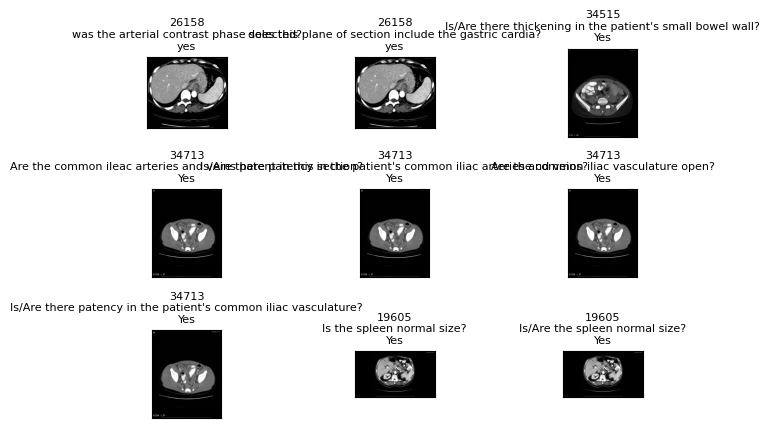

In [53]:
display_image(0)

### Image Preprocessing

In [41]:
def tilt_correction(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # find the biggest contour (c) by the area
    c = max(contours, key = cv2.contourArea)

    (x, y), (a, b), angle = cv2.fitEllipse(c)

    cv2.ellipse(img, ((x,y), (a,b), angle), color=(0, 255, 0), thickness=2)

    rmajor = max(a,b) / 2

    if angle > 90:
        angle -= 90
    else:
        angle += 96

    xtop = x + math.cos(math.radians(angle))*rmajor
    ytop = y + math.sin(math.radians(angle))*rmajor
    xbot = x + math.cos(math.radians(angle+180))*rmajor
    ybot = y + math.sin(math.radians(angle+180))*rmajor
    cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

    plt.imshow(img)
    plt.show()

    M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  # transformation matrix
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

    plt.imshow(img)
    plt.show()

def subimage(image, center, theta, width, height):

   ''' 
   Rotates OpenCV image around center with angle theta (in deg)
   then crops the image according to width and height.
   '''

   # Uncomment for theta in radians
   #theta *= 180/np.pi

   shape = ( image.shape[1], image.shape[0] ) # cv2.warpAffine expects shape in (length, height)

   matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 )
   image = cv2.warpAffine( src=image, M=matrix, dsize=shape )

   x = int( center[0] - width/2  )
   y = int( center[1] - height/2 )

   image = image[ y:y+height, x:x+width ]

   return image


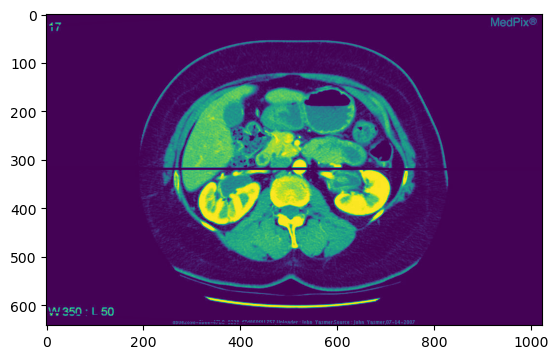

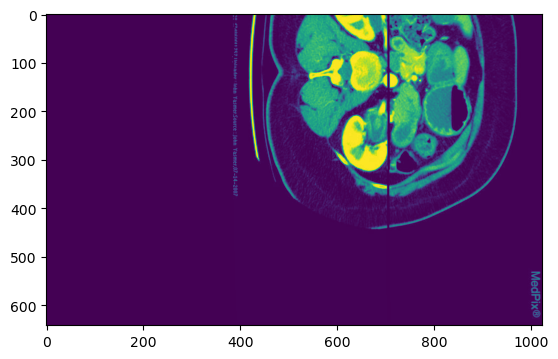

In [56]:
import random
n = random.randint(0, len(trainset))
subimage(load_image(n), (0,0), 0, 100, 100)
tilt_correction(load_image(n))

In [43]:
def crop(img):
    mask = img == 0

    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    croped = img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

    return croped

def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    # Replace the pixels with the image's pixels
    # mask_a = copy.deepcopy(final_image)
    # mask_a[:image.shape[0], :pad_left + width] = image
    # mask_b = copy.deepcopy(final_image)
    # mask_b[:pad_top + height, pad_left:pad_left + width] = image
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image

    return final_image

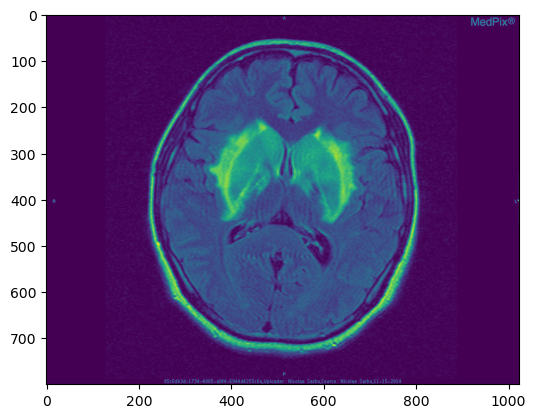

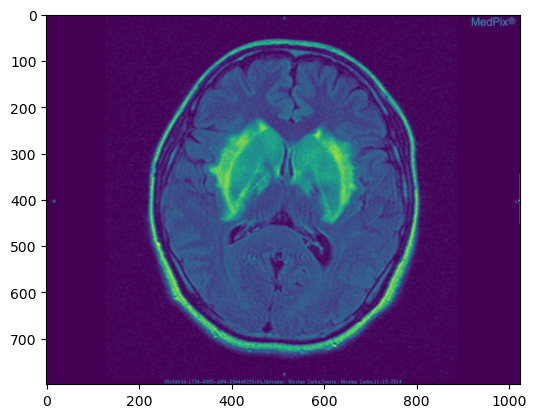

In [55]:
img = cv2.imread(str(IMAGES_DIR / 'synpic60703.jpg'), cv2.CV_8UC1)
out = crop(img)

plt.imshow(img)
plt.show()
plt.imshow(out)
plt.show()

In [62]:
def update_hu(img, ww, wl, dst_range=(0, 1)):
    src_min = wl - ww / 2
    src_max = wl + ww / 2
    outputs = (img - src_min) / ww * (dst_range[1] - dst_range[0]) + dst_range[0]
    outputs[img >= src_max] = 1
    outputs[img <= src_min] = 0
    
    outputs *= 255

    return outputs

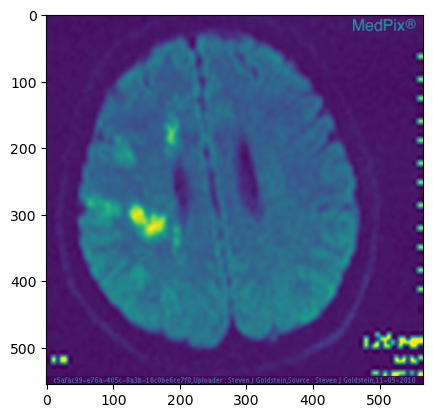

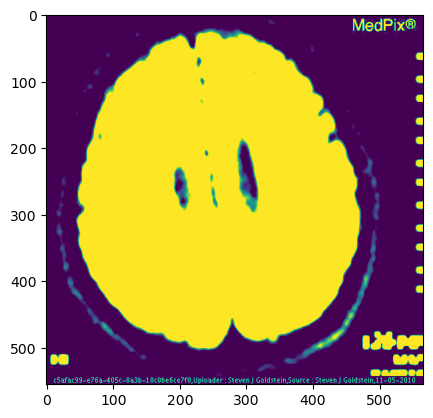

In [68]:
img = load_image(0)
plt.imshow(img)
plt.show()
output = update_hu(img, 24, 34)
plt.imshow(output)
plt.show()